# Do spectrograms tell the full story?

Current deep learning models for detecting and classifying marine biological sounds almost exclusively operate on the spectral representation of the sound, i.e., the models take as their input spectrograms and not the raw waveform. 

However, in transforming the waveform to a spectrogram, we invariably lose information. Specifically, we discard the relative phase of the various frequency components while only holding on to their magnitude. Therefore, a relevant question becomes: Does the phase contain useful information for detecting and classifying sounds? Or, posing the same question a little differently, does the spectrogram tell the full story?

In this tutorial, we will explore this question using the Griffin-Lim inversion algorithm. Given knowledge of the magnitude *and* the relative phase of the frequency components, the Griffin-Lim algorithm is able to accurately estimate the original waveform from the spectrogram. Given only the magnitude, the algorithm can still estimate the original waveform, but the estimate will not be fully accurate because the relative phase is unknown.

In this case, a human listener can assess the accuracy of inversion by aurally comparing the estimated waveform and the original waveform. Should the human listener not be able to distinguish the two sounds, it could then be concluded that the phase is not important for the task of detecting and classifying such sounds - at least when that task is carried out by a human.


### References

D. W. Griffin and J. S. Lim, “Signal estimation from modified short-time Fourier transform,” IEEE Trans. ASSP, vol.32, no.2, pp.236–243, Apr. 1984.

## Technical notes

This notebook requires [Ketos](https://docs.meridian.cs.dal.ca/ketos/) v2.5 or higher.

## A simple, synthetic audio signal

In the following, we illustrate the steps of waveform estimation using a simple harmonic signal with a Gaussian envelope, also known as a Morlet wavelet. 

We create a Morlet wavelet signal with a sampling rate of 1 kHz, a frequency of 30 Hz, an envelope 1-sigma width of 0.1 s, and a duration of 1.0 s. Also, by setting `displacement=0.25/30` we shift the signal temporally by 1/4 of a period, i.e., a phase shift of 90$^{\circ}$ or $\pi / 2$. 

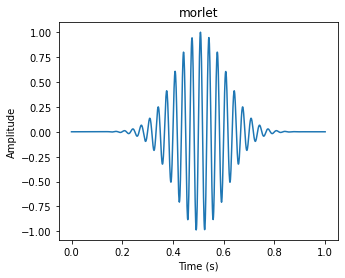

In [1]:
from ketos.audio.waveform import Waveform

wf = Waveform.morlet(rate=1000, frequency=30., width=0.1, displacement=0.25/30., samples=1000)

fig = wf.plot()

Next, we transform the waveform to a magnitude spectrogram using a window size of 0.2 s and a step size of 0.04 s.

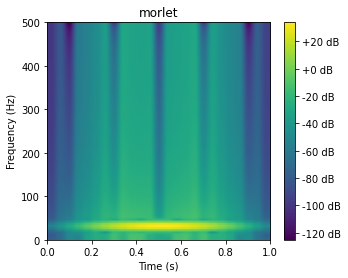

In [2]:
from ketos.audio.spectrogram import MagSpectrogram

spec = MagSpectrogram.from_waveform(audio=wf, window=0.2, step=0.04)

fig = spec.plot()

Finally, we use the Griffin-Lim algorithm to estimate the original waveform from the spectrogram. 

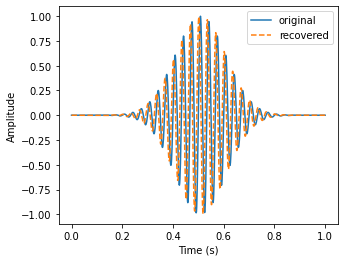

In [3]:
from ketos.audio.waveform import plot

wf_r = spec.recover_waveform(num_iters=25)  #Ketos implementation of the Griffin-Lim algorithm

fig = plot([wf, wf_r], labels=['original', 'recovered'])  #plot the two waveforms on top of one another

Note the warning message that is printed when we attempt to estimate the original waveform!

The two waveforms look fairly similar, but when we zoom in, we see that the are actually displaced by 1/4 of a period:

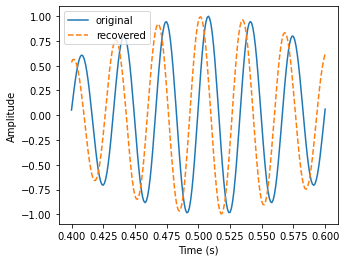

In [4]:
fig = plot([wf, wf_r], labels=['original', 'recovered'], offset=0.4, duration=0.2)

To resolve the phase discrepancy, we have to go back to the spectrogram computation step and repeat the computation with `compoute_phase=True`:

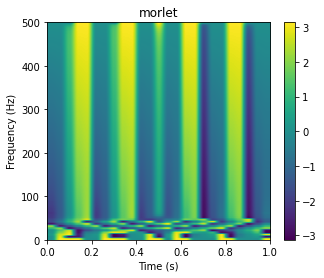

In [5]:
spec = MagSpectrogram.from_waveform(audio=wf, window=0.2, step=0.04, compute_phase=True)

fig = spec.plot_phase_angle()  #plot the phase matrix

The phase matrix looks a bit funny, but as expected the values range from $-\pi$ to $+\pi$.

Now, repeating the inversion step, the estimated waveform is in perfect agreement with the original waveform:

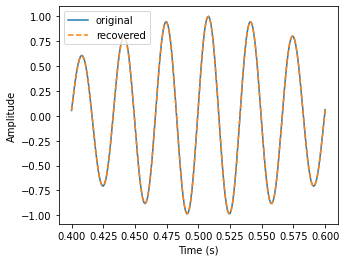

In [6]:
wf_r = spec.recover_waveform(num_iters=25)
fig = plot([wf, wf_r], labels=['original', 'recovered'], offset=0.4, duration=0.2)

## A realistic orca call

In the following, we repeat the above exercise using a realistic orca call. Specifically, we will be using the S1 call example from the [Ford-Osborne call catalog](https://www.orcasound.net/FordOsborneVocabulary/_SouthernVocabularyTable.html). 

We begin by loading the waveform, removing the first 3.5 s of the sound clip which contain human speech. (We also reduce the sampling rate slightly from the original 44100 Hz to 44000 Hz, as this makes it a little easier to chose reasonable values for the window and step size later on.)

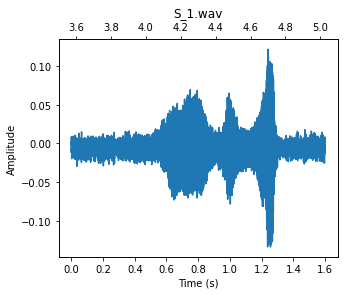

In [7]:
wf = Waveform.from_wav("S_1.wav", offset=3.5, duration=1.6, rate=44000)

fig = wf.plot()

As before, we proceed to computing the spectrogram, this time using a window size of 0.040 s and a step size of 0.010 s, and displaying both the magnitude and phase matrices.

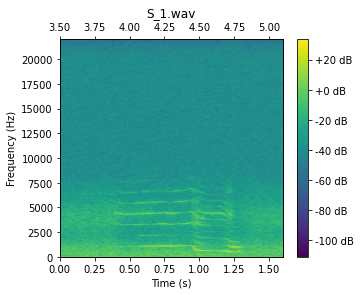

In [8]:
spec = MagSpectrogram.from_waveform(wf, window=0.040, step=0.010, compute_phase=True)

fig = spec.plot()

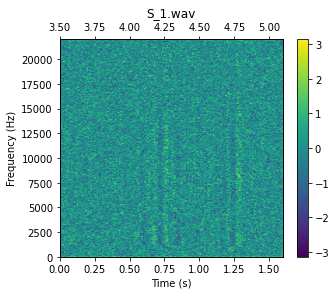

In [9]:
fig = spec.plot_phase_angle()

We use the `recover_waveform` method to estimate the original waveform from the spectrogram:

In [10]:
wf_r = spec.recover_waveform(num_iters=25)

Next, we repeat the estimation, but this time we first distort the phase matrix by applying random shifts to each entry in the matrix. Note that the distortion is maximal in the sense that the shifts are sampled uniformly from $(0,2\pi)$. 

In [11]:
import numpy as np
phi = spec.get_phase_angle() #retrieve the phase matrix
phi += np.random.uniform(0, 2*np.pi, size=phi.shape) #distort the phase matrix
wf_m = spec.recover_waveform(num_iters=25, phase_angle=phi) #estimate the waveform

Finally, we plot the original waveform together with the two estimates, one obtained using the correct phase matrix and the other obtained using the (maximally) distorted phase matrix.

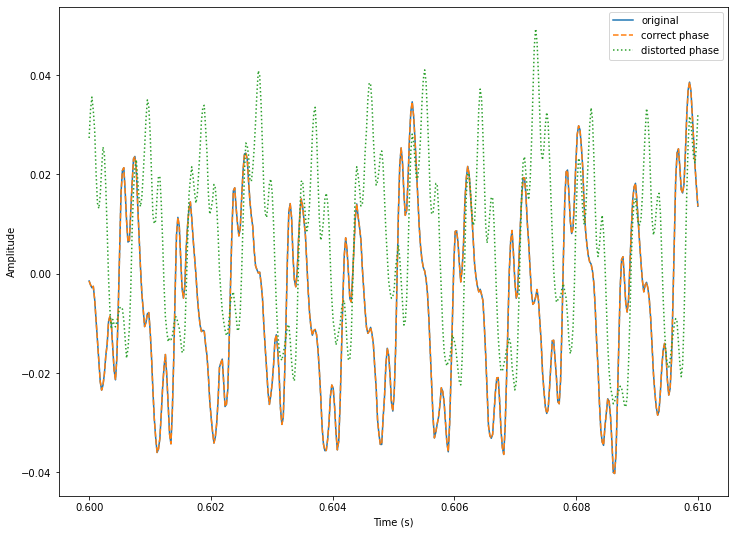

In [12]:
fig = plot([wf, wf_r, wf_m], labels=['original', 'correct phase', 'distorted phase'], offset=0.6, duration=0.01, figsize=(12,9))

As seen above, good agreement is obtained only when the correct phase is used. We may quantify the deviation between the waveforms as follows,

In [13]:
y = wf.get_data()
y_r = wf_r.get_data()
y_m = wf_m.get_data()

err_r = np.std(y - y_r) / np.std(y)
err_m = np.std(y - y_m) / np.std(y)

print(f"Relative error using actual phase: {err_r:.2g}") 
print(f"Relative error using modified phase: {err_m:.2g}") 

Relative error using actual phase: 0.00094
Relative error using modified phase: 1.5


Finally, we may listen to the three audio signals to determine if they can be distinguished aurally.

In [14]:
import IPython.display as ipd

ipd.clear_output()

print('Original signal:')
ipd.display(ipd.Audio(data=wf.get_data(), rate=wf.rate))

print('Estimated signal using the correct phase:')
ipd.display(ipd.Audio(data=wf_r.get_data(), rate=wf_r.rate))

print('Estimated signal using the distorted phase:')
ipd.display(ipd.Audio(data=wf_m.get_data(), rate=wf_m.rate))

Original signal:


Estimated signal using the correct phase:


Estimated signal using the distorted phase:


## Conclusion

Can you hear a difference between the second and third clip? If there is a difference, it is certainly a subtle one ...